### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
# Computational packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

# General packages
import datetime
import sys
import os

# custom packages
import ratsimulator
from ratsimulator.Environment import Rectangle
import spatial_maps as sm # CINPLA spatial maps

# avoid adding multiple relave paths to sys.path
sys.path.append("../../src") if "../../src" not in sys.path else None 
from PlaceCells import PlaceCells
from Models import SorscherRNN
from Experiment import Experiment
from methods import *
from datahandling import *

### Setup Experiment

In [3]:
experiment = Experiment(name = '3ME_large_batch')
if experiment.is_new_experiment:
    experiment.params['nepochs'] = 1000
    experiment.params['batch_size'] = 600
    for i in range(1,3):
        environments, agents, pc_ensembles = experiment.get_default_ecology(seed = i)
        experiment.environments += environments
        experiment.agents += agents
        experiment.pc_ensembles += pc_ensembles

experiment.setup()

Experiment <3ME_large_batch> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


False

In [4]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

device=device(type='cuda')


### Initialise objects

In [5]:
# Initialise data loading
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

# Initialise model
model = SorscherRNN(pc_ensembles, Ng=params['Ng'], Np=params['Np'])
model.to(device)
print(f"{model = }")

# Initialise optimizer (use custom weight decay, rather than torch optim decay)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], betas=(0.9, 0.999), \
                             eps=1e-08, weight_decay=0.0, amsgrad=False)

model = SorscherRNN(
  (init_position_encoder): Linear(in_features=512, out_features=4096, bias=False)
  (RNN): RNN(2, 4096, bias=False, batch_first=True)
  (decoder): Linear(in_features=4096, out_features=512, bias=False)
)


### Train/Load Model

In [6]:
logger = None
checkpoint_filenames = filenames(paths['checkpoints'])

if checkpoint_filenames:
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}")
    checkpoint = torch.load(paths['checkpoints'] / checkpoint_filenames[-1])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    with open(paths["experiment"] / "logger.pkl", "rb") as f:
        logger = pickle.load(f)
    print("Loaded weights")
    
    if isinstance(datasampler, CLSampler):
        datasampler.epoch_counter = len(loss_history)
    
# whether to train
if train:=True:
    logger = model.train(trainloader = dataloader, optimizer = optimizer, weight_decay=params['weight_decay'], \
                               nepochs=params['nepochs'], paths=paths, logger=logger)
    # (re)load checkpoint strs and latest checkpoint
    checkpoint_filenames = filenames(paths['checkpoints'])
    checkpoint = torch.load(paths['checkpoints'] / checkpoint_filenames[-1])

Loading model at epoch = 00999
Loaded weights


0it [00:00, ?it/s]


## **Analyse Model**
### Training history

In [7]:
logger.training_metrics['familiar']['l2_reg'] = [r.item() for r in logger.training_metrics['familiar']['l2_reg']]

In [8]:
logger.training_metrics['novel']['l2_reg'] = [r.item() for r in logger.training_metrics['novel']['l2_reg']]

In [9]:
logger.training_metrics['familiar']['pred_error'] = [r.item() for r in logger.training_metrics['familiar']['pred_error']]

In [10]:
logger.training_metrics['novel']['pred_error'] = [r.item() for r in logger.training_metrics['novel']['pred_error']]

In [11]:
logger.training_metrics['familiar']['true_error'] = [r.item() for r in logger.training_metrics['familiar']['true_error']]
logger.training_metrics['novel']['true_error'] = [r.item() for r in logger.training_metrics['novel']['true_error']]

CE
entropy
KL
l2_reg
pred_error
true_error
CE
entropy
KL
l2_reg
pred_error
true_error
Maximum Entropy possible: 6.2383246250395095


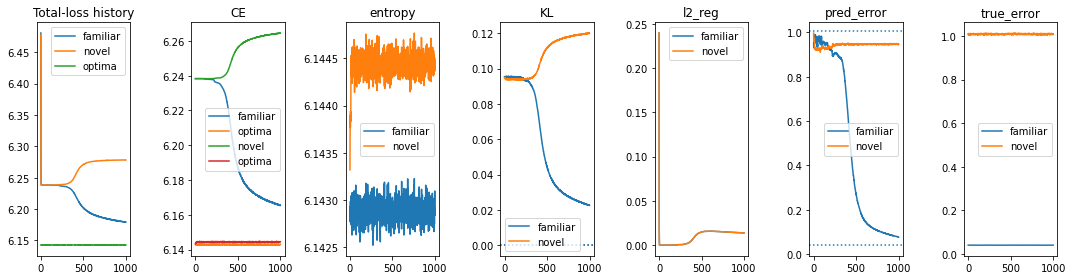

In [12]:
fig, ax = plt.subplots(ncols=len(logger.training_metrics['familiar']) + 1,figsize=(15,4))
ax[0].plot(logger.loss_history['familiar'], label='familiar')
ax[0].plot(logger.loss_history['novel'], label='novel')
ax[0].plot(logger.training_metrics['familiar']['entropy'], label='optima')
ax[0].set_title('Total-loss history')
ax[0].legend()

for i,(key,value) in enumerate(logger.training_metrics['familiar'].items()):
    print(key)
    ax[i+1].plot(value, label='familiar')
    ax[i+1].set_title(key)
    if key == 'KL':
        ax[i+1].axhline(0,ls=":")
    if key == 'pred_error':
        ax[i+1].axhline(np.mean(logger.training_metrics['familiar']['true_error']),ls=":")
    if key == 'CE':
        ax[i+1].plot(logger.training_metrics['familiar']['entropy'], label='optima')
    ax[i+1].legend()
        
for i,(key,value) in enumerate(logger.training_metrics['novel'].items()):
    print(key)
    ax[i+1].plot(value, label='novel')
    ax[i+1].set_title(key)
    if key == 'KL':
        ax[i+1].axhline(0,ls=":")
    if key == 'pred_error':
        ax[i+1].axhline(np.mean(logger.training_metrics['novel']['true_error']),ls=":")
    if key == 'CE':
        ax[i+1].plot(logger.training_metrics['novel']['entropy'], label='optima')
    ax[i+1].legend()

plt.tight_layout()

# maximum labelled distribution entropy (uniform labelled distribution)
n = 512
px = np.ones(n) / n # uniform
entropy = lambda x: -np.sum(x * np.log(x))
print(f"Maximum Entropy possible: {entropy(px)}")

### Create ratemaps

In [13]:
def ratemap_trajectories(dataset, environment_idx, num_trajectories=1500):
    """Generate trajectories to compute ratemaps with (scipy.stats.binned_statistics_2d)"""
    batch_velocities, batch_init_pc_positions, batch_positions = [], [], []
    for _ in range(num_trajectories):
        (velocities, init_pc_positions), _, positions, _ = dataset[environment_idx]
        batch_velocities.append(velocities)
        batch_init_pc_positions.append(init_pc_positions)
        batch_positions.append(positions)
    batch_inputs = [torch.stack(batch_velocities), torch.stack(batch_init_pc_positions)]
    batch_positions = torch.stack(batch_positions).detach().numpy()
    x = np.ravel(batch_positions[:,1:,0])
    y = np.ravel(batch_positions[:,1:,1])
    return batch_inputs, x, y

def ratemaps_all_checkpoints(missing_ratemaps_filenames, epoch_ratemaps_env_path, batch_inputs, x, y):
    # loop all saved model weights - and create ratemaps
    for checkpoint_epoch in tqdm.tqdm(missing_ratemaps_filenames):
        epoch_ratemaps_path = epoch_ratemaps_env_path / (checkpoint_epoch + ".pkl")
        
        # load model weights, forward (to g) and compute ratemaps
        checkpoint = torch.load(paths['checkpoints'] / checkpoint_epoch)
        model.load_state_dict(checkpoint['model_state_dict'])
        activities = model.g(batch_inputs).detach().cpu().numpy()
        activities = activities.reshape(-1, activities.shape[-1]).T
        ratemaps = scipy.stats.binned_statistic_2d(x, y, activities, bins=res)[0]
        
        # save ratemaps
        with open(epoch_ratemaps_path, "wb") as f:
            pickle.dump(ratemaps,f)

# mec_idxs = slice(0, params['Ng'], 1)
res = np.array([32, 32])
for env_i in range(len(environments)):
    print(f"Creating ratemaps for environment_idx = {env_i+1}/{len(environments)}")
    # create list of missing ratemaps - to be created
    ratemaps_filenames = filenames(paths["ratemaps"] / f"env_{env_i}")
    ratemaps_filenames = [ratemaps_filename.split('.')[0] for ratemaps_filename in ratemaps_filenames]
    missing_ratemaps_filenames = list(set(checkpoint_filenames) - set(ratemaps_filenames))
    missing_ratemaps_filenames.sort()
    if not missing_ratemaps_filenames:
        continue
    
    # generate trajectories to compute ratemaps for
    batch_inputs, x, y = ratemap_trajectories(dataset, environment_idx=env_i, num_trajectories=1500)
    
    epoch_ratemaps_env_path = paths["ratemaps"] / f"env_{env_i}"
    # loop all saved model weights - and create ratemaps
    ratemaps_all_checkpoints(missing_ratemaps_filenames,\
                             epoch_ratemaps_env_path,\
                             batch_inputs\
                             , x, y)

Creating ratemaps for environment_idx = 1/3


100%|███████████████████████████████████████████| 31/31 [00:43<00:00,  1.41s/it]


Creating ratemaps for environment_idx = 2/3


100%|█████████████████████████████████████████| 101/101 [02:20<00:00,  1.39s/it]


Creating ratemaps for environment_idx = 3/3


100%|█████████████████████████████████████████| 101/101 [02:20<00:00,  1.39s/it]


### Create ratemaps for novel environment

In [14]:
novel_environments, novel_agents, novel_pc_ensembles = Experiment.get_default_ecology(seed = 23031994)
novel_dataset = Dataset(agents = novel_agents, pc_ensembles = novel_pc_ensembles, num_samples = num_samples, **params)

print(f"Creating ratemaps for novel environment_idx = 1/1")
# create list of missing ratemaps - to be created
epoch_ratemaps_env_path = paths["ratemaps"] / "env_novel"
if not epoch_ratemaps_env_path.exists():
    os.makedirs(epoch_ratemaps_env_path)
ratemaps_filenames = filenames(paths["ratemaps"] / "env_novel")
ratemaps_filenames = [ratemaps_filename.split('.')[0] for ratemaps_filename in ratemaps_filenames]
missing_ratemaps_filenames = list(set(checkpoint_filenames) - set(ratemaps_filenames))
missing_ratemaps_filenames.sort()

if missing_ratemaps_filenames:
    # generate trajectories to compute ratemaps for
    batch_inputs, x, y = ratemap_trajectories(dataset, environment_idx=0, num_trajectories=1500)
    # loop all saved model weights - and create ratemaps
    ratemaps_all_checkpoints(missing_ratemaps_filenames,\
                             epoch_ratemaps_env_path,\
                             batch_inputs,\
                             x, y)

Singular matrix
Singular matrix
Creating ratemaps for novel environment_idx = 1/1


100%|█████████████████████████████████████████| 101/101 [02:23<00:00,  1.43s/it]


### Load ratemaps

In [15]:
env_i = 0
latest_ratemaps_path = paths["ratemaps"] / f"env_{env_i}" / (checkpoint_filenames[-1] + ".pkl")
with open(latest_ratemaps_path, "rb") as f:
    ratemaps = pickle.load(f)
print("Loaded ratemaps")

Loaded ratemaps


### Example ratemaps (unsorted)

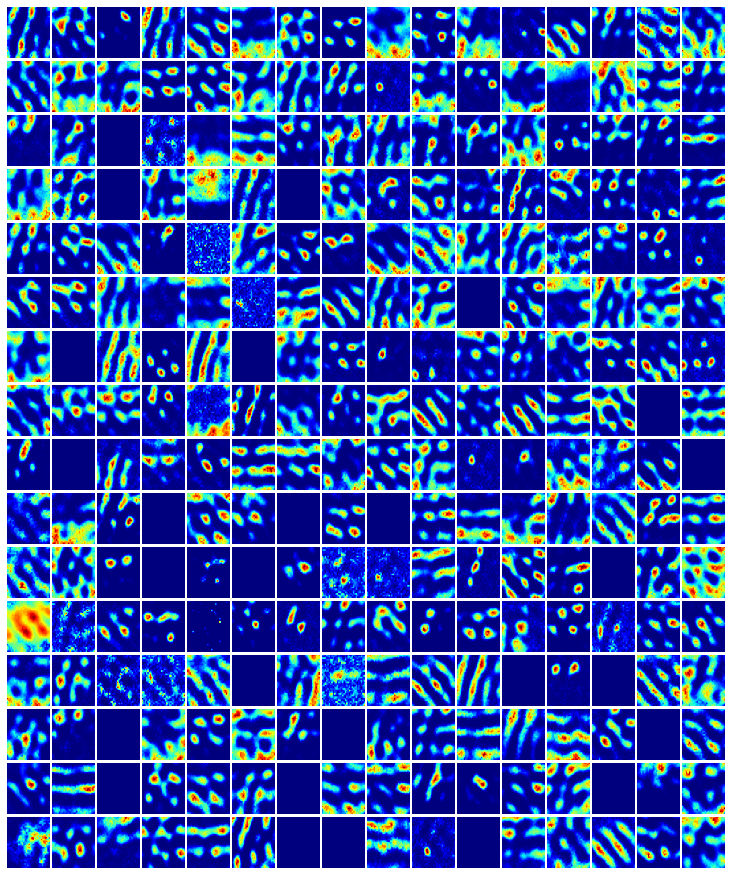

In [16]:
start_idx = 256*1
num_ratemaps = 256
fig, ax = multiimshow(ratemaps[start_idx:start_idx+num_ratemaps])

### Grid score ratemaps (only last model checkpoint)

In [17]:
def score_ratemaps(ratemaps, environment, env_name):
    # if grid scores have already been calculate and saved to disk, load these (FAST!)
    score_map_path = paths["grid_scores"] / (checkpoint_filenames[-1] + env_name + ".pkl")
    if os.path.exists(score_map_path):
        print(os.path.split(score_map_path)[-1], "already exists. Loading score map.")
        with open(score_map_path, "rb") as f:
            score_map = pickle.load(f)
        return score_map
    
    # BANINO (and Sorscher) grid scoring method
    from scores import GridScorer
    res = np.array([32,32])
    starts = [0.2] * 10
    ends = np.linspace(0.4, 1.0, num=10)
    box_width, box_height = environment.boxsize
    coord_range=((environment.origo[0], box_width), (environment.origo[0], box_height))
    coords_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
    mask_parameters = zip(starts, ends.tolist())
    scorer = GridScorer(nbins=res[0], coords_range=coords_range, mask_parameters=mask_parameters)

    # score ratemaps (Could use NUMBA for faster computations?)
    score_map = np.zeros(params['Ng']) # ratemap score lookup table
    for i in tqdm.trange(params['Ng']):
        # interpolated_ratemap = interpolate_missing_pixels(ratemaps[i], np.isnan(ratemaps[i]))
        # score_map[i] = sm.gridness(interpolated_ratemap)
        score_60, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(ratemaps[i])
        score_map[i] = score_60

    with open(score_map_path, "wb") as f:
        pickle.dump(score_map,f)
    return score_map

# create scores for all ratemaps across all environments
for env_i in range(len(environments)):
    print(f"Calculating grid score for the ratemaps of environment={env_i+1}/{len(environments)}")
    latest_ratemaps_path_env_i = paths["ratemaps"] / f"env_{env_i}" / (checkpoint_filenames[-1] + ".pkl")
    with open(latest_ratemaps_path_env_i, "rb") as f:
        ratemaps_env_i = pickle.load(f)
    score_map = score_ratemaps(ratemaps_env_i, environments[env_i], f"_env_{env_i}")
# create scores for all ratemaps of novel environment
print(f"Calculating grid score for novel environment")
with open(paths["ratemaps"] / "env_novel" / (checkpoint_filenames[-1] + ".pkl"), "rb") as f:
    ratemaps_env_novel = pickle.load(f)
score_map_env_novel = score_ratemaps(ratemaps_env_novel, novel_environments[0], "_env_novel")

# choose score map
env_i = 0
score_map = score_ratemaps(ratemaps, environments[env_i], f"_env_{env_i}")

# sort scores and ratemaps
sort_idxs = np.argsort(score_map)[::-1]
sorted_scores = score_map[sort_idxs]

Calculating grid score for the ratemaps of environment=1/3


  0%|                                                  | 0/4096 [00:00<?, ?it/s]/home/vemundss/Dropbox/PhD BI-KI/Prosjekter/emergent-grid-cells/notebooks/experiments/../../src/scores.py:141: RuntimeWarning: invalid value encountered in true_divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))
100%|███████████████████████████████████████| 4096/4096 [02:17<00:00, 29.85it/s]


Calculating grid score for the ratemaps of environment=2/3


100%|███████████████████████████████████████| 4096/4096 [02:17<00:00, 29.84it/s]


Calculating grid score for the ratemaps of environment=3/3


100%|███████████████████████████████████████| 4096/4096 [02:16<00:00, 29.97it/s]


Calculating grid score for novel environment


100%|███████████████████████████████████████| 4096/4096 [02:16<00:00, 29.99it/s]

00999_env_0.pkl already exists. Loading score map.


### Example ratemaps (sorted)

Text(0.5, 0.98, 'gc_score = 1.3907057146128785 -- 1.1097383382563781')

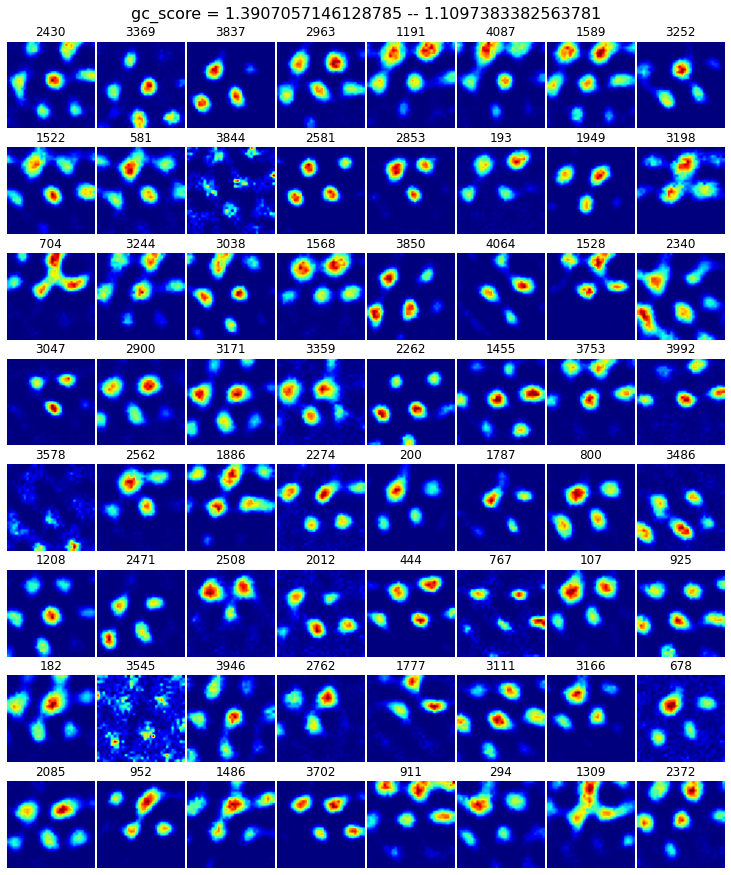

In [18]:
start_idx = 0
num_ratemaps = 2**6
fig, axs = multiimshow(ratemaps[sort_idxs][start_idx:start_idx+num_ratemaps], titles=sort_idxs[start_idx:start_idx+num_ratemaps])
fig.suptitle(f"gc_score = {sorted_scores[start_idx]} -- {sorted_scores[start_idx+num_ratemaps]}", fontsize=16)

### Create grid cell ratemap dynamics (grid cell emergence video)

Creating grid dynamics for the ratemaps of environment=1/3
Loading ratemaps


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.54it/s]


Creating videos


  0%|                                                    | 0/64 [01:19<?, ?it/s]


ValueError: unknown file extension: .mp4

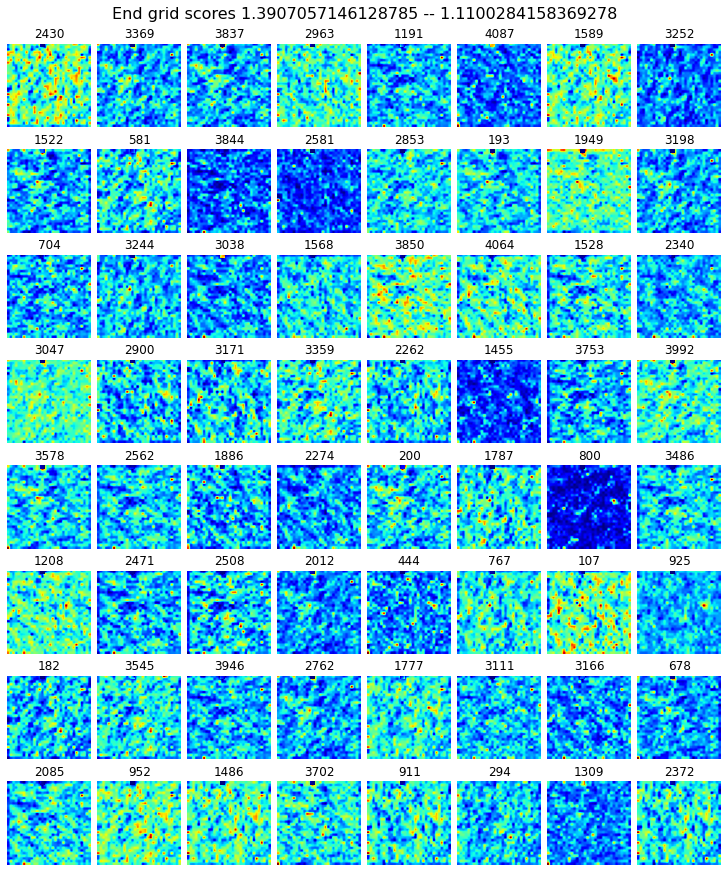

In [19]:
from dynamics import RatemapDynamics
for env_i in range(len(environments)):
    print(f"Creating grid dynamics for the ratemaps of environment={env_i+1}/{len(environments)}")
    
    # concatenating ratemaps
    ratemap_dynamics = []
    print("Loading ratemaps")
    for checkpoint_epoch in tqdm.tqdm(checkpoint_filenames):
        with open(paths["ratemaps"] / f"env_{env_i}" / (checkpoint_epoch + ".pkl"), "rb") as f:
            # load and sort ratemaps wrt. grid score
            ratemap_dynamics.append(pickle.load(f)[sort_idxs])
    ratemap_dynamics = np.stack(ratemap_dynamics, axis=0)
    
    # creating videos from ratemaps
    num_gc_in_video = 64
    num_videos = params['Ng'] // num_gc_in_video
    print("Creating videos")
    for gcs_i in tqdm.trange(0, num_videos):
        idxs = slice(gcs_i * num_gc_in_video, (gcs_i + 1) * num_gc_in_video)
        if os.path.exists(paths["dynamics"] / f"env_{env_i}" / f'{idxs.start}-{idxs.stop - 1}.mp4'):
            continue
        ratemap_video = RatemapDynamics(ratemap_dynamics[:,idxs], sorted_scores[idxs], sort_idxs[idxs], epochs = checkpoint_filenames)
        ratemap_video.animation.save(paths["dynamics"] / f"env_{env_i}" / f'{idxs.start}-{idxs.stop - 1}.mp4')

### Predicted place Cells (with(out) SOFTMAX)

In [ ]:
"""
forward_with_softmax = lambda x: torch.exp(model(x, log_softmax=True))
ratemaps = compute_ratemaps(model=model, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]
fig, ax = multiimshow(ratemaps)
"""

In [ ]:
model.prune_mask = list(range(int(4096/2),4096)) # set prune mask
model.prune_mask = [] # reset prune mask
model.prune_mask

In [ ]:
idxs=slice(0, 16**2, 1)
res=np.array([32, 32])
ratemaps = compute_ratemaps(model=model.g, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]
fig, ax = multiimshow(ratemaps)

### Decoding labels and predictions to cartesian

In [ ]:
environment_idx = 0
[[vel, init_pos], labels, positions, index] = dataset[environment_idx]
true_cartesian_pos = positions
true_decoded_pos = pc_ensembles[environment_idx].to_euclid(torch.cat([init_pos[None], labels]))
pc_preds = model([vel, init_pos]).detach().cpu()[0]
predicted_decoded_pos = pc_ensembles[environment_idx].to_euclid(torch.cat([init_pos[None], pc_preds]))

In [ ]:
fig, ax = plt.subplots()
ax.plot(*true_cartesian_pos.T, label='true_cartesian_pos')
ax.plot(*true_decoded_pos.T, label='true_decoded_pos')
ax.plot(*predicted_decoded_pos.T, label='predicted_decoded_pos', ls=':')
environments[environment_idx].plot_board(ax)
ax.legend()

### Plot all place cell centers and some with tuning curves

In [ ]:
fig, ax = plt.subplots()
x,y = pc_ensembles[environment_idx].pcs.T

ax.plot(x, y, "+")
# add standard deviation circles to locations
for i in range(5):
    ax.plot(x[i], y[i], "r+")
    a_circle = plt.Circle((x[i], y[i]), pc_ensembles[0].pc_width, fill=False, color=(1, 0, 0, 0.5))
    ax.add_artist(a_circle)

plt.title("Spatial plot of place cell locations")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Calculate grid scores using different implementations of the metric

In [ ]:
# Custom grid score
print("CUSTOM:", grid_score(ratemaps[1])) 

# CINPLA grid score
import spatial_maps as sm
print("CINPLA:", sm.gridness(ratemaps[1])) 

# BANINO (and Sorscher) grid scoring
from scores import GridScorer
"""
One difference from custom and CINPLA grid scores: 
1. Uses average difference between phase60 and phase30 correlations
"""
starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
coord_range=((0, environment.boxsize[0]), (0, environment.boxsize[1]))
box_width, box_height = 2.2, 2.2
coords_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
mask_parameters = zip(starts, ends.tolist())
scorer = GridScorer(nbins=res[0], coords_range=coords_range, mask_parameters=mask_parameters)

#score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip(
#      *[scorer.get_scores(rm.reshape(res, res)) for rm in tqdm(rate_map_lores)])
score_60, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(ratemaps[1])
print("BANINO/SORSCHER:", score_60)

In [ ]:
# choose grid scoring function to use, e.g: grid_score, sm.gridness or scorer.get_scores
# for scorer.get_scores use: < (lambda rm: scorer.get_scores(rm)[0])(rate_map) >
grid_scoring_fn = lambda rate_map: sm.gridness(rate_map)

#map(grid_scoring_fn, *ratemaps)
grid_scoring_fn(ratemaps[1])

### Small analysis / checks / tests etc

In [ ]:
# Wr = model.recurrence.weight.detach().cpu().numpy()
Wr = model.RNN.weight_hh_l0.detach().cpu().numpy()
stats = lambda W : print(f"{np.min(W)=}, {np.max(W)=}, {np.min(abs(W))=}, {np.mean(W)=}, {np.std(W)=}, {np.sum(W**2)=}")
stats(Wr)
plt.imshow(Wr[:25,:25])
plt.colorbar()

In [ ]:
Wp = model.init_position_encoder.weight.detach().cpu().numpy()
stats(Wp)
plt.imshow(Wp)
plt.colorbar()